In [ ]:
pip install sacrebleu

# Libraries

In [ ]:
import pandas as pd
import io
import re
import string
import nltk
import sentencepiece as spm
import tempfile
import torch
import torch.nn as nn
import math
import sacrebleu
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

we're gonna use wikimedia dataset, Baby 

1. English sub: https://object.pouta.csc.fi/OPUS-wikimedia/v20230407/mono/en.txt.gz
2. Indo sub: https://object.pouta.csc.fi/OPUS-wikimedia/v20230407/mono/id.txt.gz

# Sample Dataset

In [ ]:
path_txt = '/kaggle/input/indo-english/indo_english.txt'
id_sentences = []
en_sentences = []

with open(path_txt, 'r', encoding='utf-8') as f:
    current_indo = None
    for line in f:
        line = line.strip()
        if line.startswith('Indonesian:'):
            current_indo = line.replace('Indonesian:', '').strip()
        elif line.startswith('English:') and current_indo is not None:
            # current_en = line.replace('English:', '').strip()
            en_sentences.append(line.replace('English:', '').strip())
            id_sentences.append(current_indo)
            current_indo = None # reset for the next pair

        elif not line and current_indo is not None:
            # current_en = None # reset for the next pair
            # just skip it
            pass
df = pd.DataFrame({
    'Indonesian': id_sentences,
    'English': en_sentences
    })
print(df.head())

# data_pairs = list(zip(id_sentences, en_sentences))
# print(f'Loaded {len(data_pairs)} sentence pairs.')

# for indo, eng in data_pairs:
#     print(f'Indonesian: {indo}')
#     print(f'English: {eng}')
#     print("-" * 20)
# df = pd.DataFrame(data_pairs, columns=['Indonesian', 'English'])

# Tatoeba Dataset

In [ ]:
path_txt = '/kaggle/input/tatoeba-ind-to-eng/mtInaEng.txt'

id_sentences = []
en_sentences = []

# encoding
with open(path_txt, 'r', encoding='utf-8') as f:
    current_indo = None
    for line in f:
        line = line.strip()
        parts = line.split('\t')
        if len(parts) >= 4 and parts[1].strip() and parts[3].strip():  # Ensure non-empty sentences
            # the second eleent is the Indo. sentence
            id_sentences.append(parts[1].strip())
            # the third element is the English sentence
            en_sentences.append(parts[3].strip())

df = pd.DataFrame({
    'Indonesian': id_sentences,
    'English': en_sentences
    })

# Check for empty or short sentences
print("Dataset stats:")
print(f"Total pairs: {len(df)}")
print(f"Empty Indonesian: {sum(df['Indonesian'] == '')}")
print(f"Empty English: {sum(df['English'] == '')}")
print(df.head())
# print(df.head())

# Preprocessing



1. Normalisasi teks (lowercasing, penanganan tanda baca)


---


2. Tokenisasi: gunakan tokenisasi berbasis subword (SentencePiece / Byte-Pair
Encoding) untuk kedua bahasa, sambil menentukan ukuran vocab (contoh: 32.000
token).


---


3. Filtering: buang pasangan kalimat ekstrem (misal terlalu panjang (>100 token)) atau terlalu pendek



* Tokenize

In [ ]:
# combine sentences
sentencens = df['Indonesian'].tolist() + df['English'].tolist()

with tempfile.NamedTemporaryFile(mode='w', encoding='utf-8', delete=False) as temp_file:
    for sentence in sentencens:
        temp_file.write(sentence + '\n')
    temp_file_path = temp_file.name

# Train SentecePiece model
spm.SentencePieceTrainer.train(
    input=temp_file_path,
    model_prefix='spm',
    vocab_size=15000,
    user_defined_symbols=['<PAD>', '<SOS>', '<EOS>','<UNK>'],
    model_type='bpe', # Byte-Pair Encoding
)

 Load spm model

In [ ]:
sp = spm.SentencePieceProcessor(model_file='spm.model')

# test tokenization
sample_sentece = df['Indonesian'].iloc[1]
tokens = sp.encode(sample_sentece, out_type=str)
token_ids = sp.encode(sample_sentece, out_type=int)
print(f'Sample sentence: {sample_sentece}')
print(f'Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

# Prepare Sequences for the Transformer


List itemTransformers expect fixed-length sequences, so you’ll need to:

1.   Convert sentences to token IDs.
Add <SOS> and <EOS> to each sequence.

2.   Pad sequences to the same length using <PAD>.



In [ ]:
def preprocess_sentence(sentence, sp, max_length):
    token_ids = sp.encode(sentence, out_type=int)
    token_ids = [sp.piece_to_id('<SOS>')] + token_ids + [sp.piece_to_id('<EOS>')]
    token_ids += [sp.piece_to_id('<PAD>')] * (max_length - len(token_ids))
    return token_ids[:max_length]  # Truncate if too long

# apply to dataframe
# Reapply preprocessing
max_length = 50  # Adjust if needed
df['Indonesian_tokenized'] = df['Indonesian'].apply(lambda x: preprocess_sentence(x, sp, max_length))
df['English_tokenized'] = df['English'].apply(lambda x: preprocess_sentence(x, sp, max_length))

# Verify <EOS> in sequences
print("Checking <EOS> in first 5 English sequences after reprocessing:")
for i in range(5):
    seq = df['English_tokenized'].iloc[i]
    print(f"Sequence {i}: {seq[-5:]}")  # Last 5 tokens
    print(f"Contains <EOS> (ID 5): {5 in seq}")
# print(df[['Indonesian', 'Indonesian_tokenized', 'English', 'English_tokenized']].head())

In [ ]:
# Check special tokens
print(f"<PAD> token ID: {sp.piece_to_id('<PAD>')}")
print(f"<SOS> token ID: {sp.piece_to_id('<SOS>')}")
print(f"<EOS> token ID: {sp.piece_to_id('<EOS>')}")
print(f"<UNK> token ID: {sp.piece_to_id('<UNK>')}")

# Building the Transformer model from scratch

Atur jumlah layer encoder/decoder (contoh 6 lapis), multi-head 

*   attention (8 head), 
embedding size ~512, feed-forward dim ~2048. 
*   ○ Latih hingga convergence, gunakan positional encoding, learning rate schedule 
(warmup + decay). 

* ○ Eksperimen: misal (a) Transformer Full (6+6 layer), (b) Transformer Ringkas (4+4 layer).





*Positional Encoding*

Transformers don’t inherently understand token order, so we add positional encodings to the input embeddings. These are fixed or learned vectors that encode the position of each token in the sequence.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)#.transpose(0, 1)
        self.register_buffer('pe',pe)

    def forward(self,x):
        return x + self.pe[:, :x.size(1), :]

Let’s outline the Transformer architecture. For a from-scratch implementation, you’ll create:

1. Embedding Layers: Convert token IDs to dense vectors for both source (Indonesian) and target (English).
2. Transformer Layers: Encoder and decoder stacks with multi-head attention.
3. Output Layer: A linear layer to predict token probabilities over the vocabulary.

**Model Size (d_model, nhead, dim_feedforward)**

What they do:
* d_model: Embedding dimension for tokens and internal representations (default: 512).
* nhead: Number of attention heads in multi-head attention (default: 8).
* dim_feedforward: Size of feed-forward layers in each Transformer layer (default: 2048).
* Smaller values reduce model capacity, which is crucial for small datasets to avoid overfitting.
  
**Why tweak:** Why tweak?: With 25k pairs, you can try a slightly larger d_model (e.g., 768) for better expressiveness, but don’t go too high (e.g., 1024) to avoid overfitting or memory issues.

**nhead:** More heads can capture diverse relationships, but too many dilute focus. For d_model=512, try 8 or 16; for d_model=768, try 12.

**dim_feedforward:** Larger FFNs add capacity but increase compute. Smaller values (e.g., 1024) may suffice for 25k pairs.
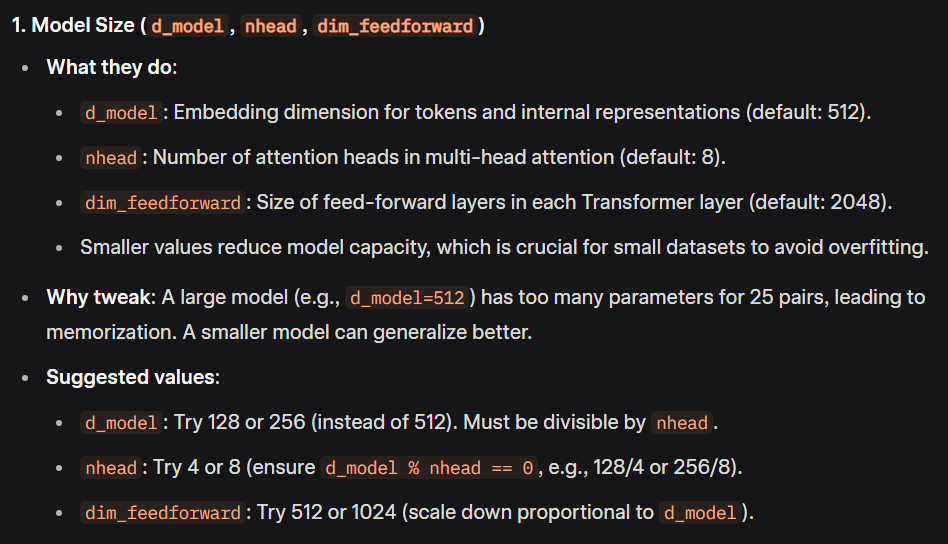

**Number of Layers (num_encoder_layers, num_decoder_layers)**
* What they do: Number of stacked layers in the encoder and decoder (default: 6 each).
* Why tweak: Deep models (6 layers) are overkill for 25 pairs, increasing overfitting risk. Fewer layers simplify the model.
* 
Suggested values: Try 1 or 2 layers for both encoder and decoder.
Example:


> *num_encoder_layers=2,num_decoder_layers=2*

**Dropout (dropout)**
* What it does: Randomly zeros out some elements during training to prevent overfitting (default: 0.1).
* Why tweak: Higher dropout regularizes the model, which is critical for small datasets.
> Suggested values: Try 0.3 or 0.5 (more aggressive than 0.1).

**Learning Rate (lr)**

* What it does: Learning Rate (lr): Controls step size for optimization (default: 0.0001 in your code).
* Why tweak: Too high causes instability; too low slows convergence. For Transformers, a dynamic schedule (e.g., warmup) often works better.

> Suggested values: Test lr=0.0001 (baseline), lr=0.0003, and add a warmup schedule (see below).

**Dropout:** Regularization to prevent overfitting (default: 0.1).
* Why tweak?: With 25k pairs, slight overfitting is possible. Higher dropout (e.g., 0.3) can improve generalization.
> Suggestion: Test dropout=0.1 and 0.3.

**Warmup Steps** 
Gradually increase the learning rate over the first few thousand steps, then decay.
> Why tweak?: Helps stabilize training for Transformers. Common for machine translation.
Suggestion: Use 4000 warmup steps with inverse square root decay
>

**Batch Size**
* What it does: Number of sentence pairs processed per training step (default: 32 in earlier code).
* Why tweak: With 25 pairs, a large batch size (e.g., 32) isn’t feasible. Smaller batches allow more frequent updates but may increase noise.
> Suggested values: Try 4 or 8 (small enough to fit your dataset).

**Number of Epochs**
* What it does: Number of times the model sees the entire dataset.
* Why tweak: Small datasets need more epochs to learn, but too many cause overfitting. Monitor validation loss to stop early.
> Suggested values: Try 50–100 epochs with early stopping (stop if validation loss stops decreasing for, e.g., 10 epochs).

**Vocabulary Size (vocab_size in SentencePiece)**
* What it does: Number of subword tokens in your SentencePiece model (default: 8000 in earlier code).
* Why tweak: With 25k pairs, a slightly larger vocab (e.g., 16,000) can capture more nuances, but too large risks sparsity.
> Suggested values: Test vocab_size=8000 (baseline) and 16,000. Retrain SentencePiece if changing.


**Max Sequence Length (max_length)**
* What it does: Maximum number of tokens per sequence (including <SOS>, <EOS>).
* Why tweak:Longer sequences capture more context but increase memory usage. Check your dataset’s token length distribution.
> Suggested values: Use the 95th percentile of token lengths (from earlier code) or test max_length=50 and 100.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=768, nhead=12, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=2048, dropout=0.3):
        super().__init__()
        self.d_model = d_model
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(
            d_model = d_model,
            nhead = nhead,
            num_encoder_layers = num_encoder_layers,
            num_decoder_layers = num_decoder_layers,
            dim_feedforward = dim_feedforward,
            dropout = dropout,
            batch_first = True,
        )
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None):
        # src: (batch_size, src_seq_len), tgt: (batch_size, tgt_seq_len)
        src_emb = self.positional_encoding(self.src_embedding(src) * math.sqrt(self.d_model))
        tgt_emb = self.positional_encoding(self.tgt_embedding(tgt) * math.sqrt(self.d_model))

        output = self.transformer(
            src_emb,
            tgt_emb,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )
        return self.fc_out(output)  # (batch_size, tgt_seq_len, tgt_vocab_size)

    def generate_square_subsequent_mask(self, sz):
        # Create a mask for the target sequence to prevent attending to future tokens
        mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
        return mask


# Prepare the DataLoader

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, df):
        self.src = [torch.tensor(seq) for seq in df['Indonesian_tokenized']]
        self.tgt = [torch.tensor(seq) for seq in df['English_tokenized']]

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]

# create dataset and dataloader
dataset = TranslationDataset(df)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Training Loop

In [ ]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for src, tgt in dataloader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()

        # Shift target for teacher forcing: input is tgt[:, :-1], target is tgt[:, 1:]
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        # create masks
        src_padding_mask = (src == sp.piece_to_id('<PAD>')).to(device)
        tgt_padding_mask = (tgt_input == sp.piece_to_id('<PAD>')).to(device)
        tgt_mask = model.generate_square_subsequent_mask(tgt_input.size(1)).to(device)

        # Forward pass
        output = model(src, tgt_input, src_key_padding_mask=src_padding_mask,
                      tgt_key_padding_mask=tgt_padding_mask, tgt_mask=tgt_mask)

        # compute loss
        loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# initialize
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Transformer(src_vocab_size=sp.get_piece_size(), tgt_vocab_size=sp.get_piece_size()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
criterion = nn.CrossEntropyLoss(ignore_index=sp.piece_to_id('<PAD>'))

print(device)
for epoch in range(20):
    model.to(device)
    criterion.to(device)
    loss = train(model, dataloader, optimizer, criterion, device)
    print(f'Epoch {epoch+1}, Loss: {loss}')

# split dataset
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = TranslationDataset(train_df)
val_dataset = TranslationDataset(val_df)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Early Stopping

Introduced early stopping for convergence

In [ ]:
def train_and_validate(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=20, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # training
        model.train()
        train_loss = 0
        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()

            # Shift target for teacher forcing: input is tgt[:, :-1], target is tgt[:,1]
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            # create masks
            src_padding_mask = (src == sp.piece_to_id('<PAD>')).to(device)
            tgt_padding_mask = (tgt_input == sp.piece_to_id('<PAD>')).to(device)
            tgt_mask = model.generate_square_subsequent_mask(tgt_input.size(1)).to(device)
            output = model(src, tgt_input, src_key_padding_mask=src_padding_mask,
                           tgt_key_padding_mask=tgt_padding_mask, tgt_mask=tgt_mask)

            loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /=  len(train_dataloader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                tgt_input = tgt[:, :-1]
                tgt_output = tgt[:, 1:]
                src_padding_mask = (src == sp.piece_to_id('<PAD>')).to(device)
                tgt_padding_mask = (tgt_input == sp.piece_to_id('<PAD>')).to(device)
                tgt_mask = model.generate_square_subsequent_mask(tgt_input.size(1)).to(device)
                output = model(src, tgt_input, src_key_padding_mask=src_padding_mask,
                               tgt_key_padding_mask=tgt_padding_mask, tgt_mask=tgt_mask)
                loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
                val_loss += loss.item()

            val_loss /= len(val_dataloader)
            val_losses.append(val_loss)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # save model (optional)
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    return train_losses, val_losses


# initialize
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Transformer(src_vocab_size=sp.get_piece_size(), tgt_vocab_size=sp.get_piece_size()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
criterion = nn.CrossEntropyLoss(ignore_index=sp.piece_to_id('<PAD>'))

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = TranslationDataset(train_df)
val_dataset = TranslationDataset(val_df)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_losses, val_losses = train_and_validate(model, train_dataloader, val_dataloader, optimizer, criterion, device, patience=5)

# run with early stopping plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Key signs of convergence:

1. Training Loss Plateaus: The training loss decreases steadily at first but then flattens out, with only small fluctuations.
2. Validation Loss Stabilizes: The validation loss also stops decreasing, indicating the model isn’t improving on unseen data.
3. Performance Metrics Improve: For translation, metrics like BLEU (from the previous step) stop increasing significantly.

# BLEU Evaluation

In [ ]:
def evaluate_bleu(model, dataloader, sp, device, max_length=50):
    model.eval()
    translations = []
    references = []
    
    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            generated = greedy_decode(model, src, sp, max_length, device)
            translations.extend([sp.decode(ids) for ids in generated])
            for ids in tgt.tolist():
                try:
                    eos_idx = ids.index(sp.piece_to_id('<EOS>'))
                    ref_ids = ids[1:eos_idx]  # Skip <SOS>, stop at <EOS>
                except ValueError:
                    ref_ids = ids[1:]  # Fallback: use all tokens after <SOS>
                    print("Warning: <EOS> not found in a reference sequence")
                references.extend([sp.decode(ref_ids)])
    
    bleu = sacrebleu.corpus_bleu(translations, [references])
    return bleu.score

def greedy_decode(model, src, sp, max_length, device):
    model.eval()
    batch_size = src.size(0)
    memory = model.transformer.encoder(model.positional_encoding(model.src_embedding(src) * math.sqrt(model.d_model)))
    ys = torch.ones(batch_size, 1).fill_(sp.piece_to_id('<SOS>')).long().to(device)

    for _ in range(max_length - 1):
        tgt_mask = model.generate_square_subsequent_mask(ys.size(1)).to(device)
        out = model.transformer.decoder(
            model.positional_encoding(model.tgt_embedding(ys) * math.sqrt(model.d_model)),
            memory,
            tgt_mask=tgt_mask
        )
        out = model.fc_out(out[:, -1, :])
        _, next_word = torch.max(out, dim=1)
        ys = torch.cat([ys, next_word.unsqueeze(1)], dim=1)
        if (next_word == sp.piece_to_id('<EOS>')).all():
            break

    return ys.tolist()

# best model so far
# model = '/kaggle/input/30_epochs/pytorch/default/1/best_model.pth'

# Evaluate
bleu_score = evaluate_bleu(model, val_dataloader, sp, device)
print(f"BLEU Score: {bleu_score:.2f}")

print("SRC:", sp.decode(src[0].tolist()))
print("PRED:", translations[0])
print("REF:", references[0])

# BEAM search decoding

In [ ]:
def beam_search_decode(model, src, sp, max_length, device, beam_size=5):
    model.eval()
    batch_size = src.size(0)
    memory = model.transformer.encoder(model.positional_encoding(model.src_embedding(src) * math.sqrt(model.d_model)))
    
    # Initialize beam
    ys = torch.ones(batch_size, 1).fill_(sp.piece_to_id('<SOS>')).long().to(device)
    beam = [(ys, 0.0)]  # (sequence, score)
    
    for _ in range(max_length - 1):
        candidates = []
        for seq, score in beam:
            if seq[:, -1].item() == sp.piece_to_id('<EOS>'):
                candidates.append((seq, score))
                continue
            tgt_mask = model.generate_square_subsequent_mask(seq.size(1)).to(device)
            out = model.transformer.decoder(
                model.positional_encoding(model.tgt_embedding(seq) * math.sqrt(model.d_model)),
                memory,
                tgt_mask=tgt_mask
            )
            out = model.fc_out(out[:, -1, :])
            probs = torch.log_softmax(out, dim=-1)
            top_probs, top_idx = probs.topk(beam_size, dim=-1)
            for i in range(beam_size):
                candidates.append((torch.cat([seq, top_idx[:, i].unsqueeze(1)], dim=1), score + top_probs[:, i].item()))
        
        # Keep top beam_size candidates
        beam = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_size]
        if all(seq[:, -1].item() == sp.piece_to_id('<EOS>') for seq, _ in beam):
            break
    
    return beam[0][0].tolist()  # Return best sequence

# Update translate_sentence
def translate_sentence(model, sentence, sp, max_length, device, beam_size=5):
    model.eval()
    token_ids = preprocess_sentence(sentence, sp, max_length)
    src = torch.tensor([token_ids]).to(device)
    generated_ids = beam_search_decode(model, src, sp, max_length, device, beam_size)
    return sp.decode(generated_ids)

# Update evaluate_bleu to use beam search
def evaluate_bleu(model, dataloader, sp, device, max_length=50, beam_size=5):
    model.eval()
    translations = []
    references = []
    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            generated = [beam_search_decode(model, src[i:i+1], sp, max_length, device, beam_size) for i in range(src.size(0))]
            translations.extend([sp.decode(ids) for ids in generated])
            references.extend([sp.decode(ids[1:ids.index(sp.piece_to_id('<EOS>'))]) for ids in tgt.tolist()])
    bleu = sacrebleu.corpus_bleu(translations, [references])
    return bleu.score

# Fluency Manual Scoring

In [ ]:
test_100 = [
  "Saya ingin memesan tiket pesawat.",
  "Berapa harga tiket ke Bali?",
  "Apakah ada penerbangan langsung?",
  "Jam berapa pesawatnya berangkat?",
  "Di mana pintu keberangkatan?",
  "Saya tersesat.",
  "Bisakah Anda menunjukkan jalannya?",
  "Di mana hotel saya?",
  "Berapa lama perjalanan ke sana?",
  "Saya ingin menyewa mobil.",
  "Di mana tempat penyewaan mobil?",
  "Berapa biaya sewa per hari?",
  "Saya mau ke pantai.",
  "Pantai mana yang bagus?",
  "Apakah ada tur yang tersedia?",
  "Berapa harga tur ini?",
  "Saya mau makan siang.",
  "Restoran apa yang direkomendasikan?",
  "Ini enak sekali.",
  "Berapa totalnya?",
  "Bisakah saya membayar dengan kartu kredit?",
  "Di mana ATM terdekat?",
  "Saya butuh taksi.",
  "Tolong panggilkan taksi.",
  "Berapa ongkosnya ke bandara?",
  "Saya mau membeli suvenir.",
  "Di mana pasar suvenir?",
  "Berapa harga ini?",
  "Bisa diskon sedikit?",
  "Saya hanya melihat-lihat.",
  "Terima kasih banyak.",
  "Sama-sama.",
  "Permisi.",
  "Maaf.",
  "Ya.",
  "Tidak.",
  "Tolong.",
  "Selamat pagi.",
  "Selamat siang.",
  "Selamat sore.",
  "Selamat malam.",
  "Apa kabar?",
  "Baik-baik saja.",
  "Nama saya [Nama Anda].",
  "Senang bertemu dengan Anda.",
  "Apakah Anda berbicara bahasa Inggris?",
  "Saya tidak mengerti.",
  "Bisa bicara pelan-pelan?",
  "Bisakah Anda mengulanginya?",
  "Di mana toiletnya?",
  "Ada wifi di sini?",
  "Apa kata sandi wifi-nya?",
  "Berapa lama saya bisa menginap?",
  "Saya ingin check-in.",
  "Saya ingin check-out.",
  "Nomor kamar saya adalah...",
  "Apakah sarapan termasuk?",
  "Jam berapa sarapan disajikan?",
  "Saya butuh handuk baru.",
  "Apakah ada layanan kamar?",
  "Di mana halte bus terdekat?",
  "Bis berapa yang menuju ke kota?",
  "Berapa ongkos bisnya?",
  "Ini stasiun mana?",
  "Apakah ini kereta ke Surabaya?",
  "Saya ingin ke sana.",
  "Bagaimana cara ke sana?",
  "Apakah tempat ini aman?",
  "Ada tempat penukaran uang?",
  "Berapa nilai tukarnya?",
  "Saya ingin membeli kartu SIM lokal.",
  "Di mana saya bisa mengisi ulang pulsa?",
  "Saya butuh peta.",
  "Apakah ada pemandu wisata?",
  "Berapa biaya pemandu wisata?",
  "Apakah tempat ini buka sekarang?",
  "Jam berapa tutup?",
  "Ini hari libur?",
  "Saya sakit.",
  "Di mana rumah sakit terdekat?",
  "Saya butuh dokter.",
  "Bolehkah saya mengambil foto?",
  "Apakah ini gratis?",
  "Apakah ada biaya masuk?",
  "Berapa biaya masuknya?",
  "Bisakah Anda merekomendasikan tempat wisata?",
  "Bagaimana cuacanya hari ini?",
  "Apakah akan hujan?",
  "Saya kedinginan.",
  "Saya kepanasan.",
  "Saya lapar.",
  "Saya haus.",
  "Saya lelah.",
  "Saya butuh istirahat.",
  "Nikmati perjalanan Anda!",
  "Hati-hati di jalan!"
]


In [ ]:
def translate_sentece(model, sentence, sp, max_length, device):
    model.eval()
    # Tokenize and preprocess
    token_ids = preprocess_sentence(sentence, sp, max_length)
    src = torch.tensor([token_ids]).to(device)  # Add batch dimension

    # Decode
    # generated_ids = greedy_decode(model, src, sp, max_length, device)[0]
    generated_ids = beam_search_decode(model, src, sp, max_length, device)[0]
    translation = sp.decode(generated_ids)
    return translation

for sentence in test_100:
    translation = translate_sentence(model, sentence, sp, max_length=50, device=device)
    print(f"Input: {sentence}")
    # sentence.to_excel('output.xlsx')
    print(f"Translation: {translation}")

In [ ]:
import pandas as pd
import torch

results = []

for sentence in test_100:
    translation = translate_sentence(model, sentence, sp, max_length=50, device=device)
    results.append({'Input': sentence, 'Translation': translation})

# Convert to DataFrame
df = pd.DataFrame(results)

# Save to Excel
df.to_excel('output.xlsx', index=False)

# Interface for Translation

In [ ]:
def translate_sentence(model, sentence, sp, max_length, device):
    model.eval()
    # Tokenize and preprocess
    token_ids = preprocess_sentence(sentence, sp, max_length)
    src = torch.tensor([token_ids]).to(device)  # Add batch dimension

    # Decode
    # generated_ids = greedy_decode(model, src, sp, max_length, device)[0]
    generated_ids = beam_search_decode(model, src, sp, max_length, device)[0]
    translation = sp.decode(generated_ids)
    return translation

# Test
sample_sentence = "ibu"
translation = translate_sentence(model, sample_sentence, sp, max_length=50, device=device)
print(f"Input: {sample_sentence}")
print(f"Translation: {translation}")